# COVID-19 Literature Clustering

In [1]:
from IPython.display import Image
#Image(filename='/kaggle/input/screen-shot/screen_shot.png', width=800) 

##### You can find the full version of the interactive plot here on GitHub: 
https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html <br>
Because of its size, I can only put the smaller version on this Notebook.

### Goal
Given the large number of literature and the rapid spread of COVID-19, it is difficult for health professionals to keep up with new information on the virus. Can we cluster similar research articles together to find related information? Clustering can be used to create a tool to identify similar articles, given a target article. It can also reduce the number of articles one has to go through as one can focus on a cluster of articles rather than all. In this notebook, we will to attempt narrow down the stream of information coming out about COVID-19.

### Table of Contents
1. Loading the data
2. Pre-processing
3. 

# Loading the Data
Load the data following the notebook by Ivan Ega Pratama, from Kaggle.
#### Cite: [Dataset Parsing Code | Kaggle, COVID EDA: Initial Exploration Tool](https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool)

### Loading Metadata

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

Let's load the metadata of the dateset. 'title' and 'journal' attributes may be useful later when we cluster the articles to see what kinds of articles cluster together.

In [3]:
root_path = 'data/CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389


In [4]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45774 entries, 0 to 45773
Data columns (total 17 columns):
cord_uid                       45774 non-null object
sha                            31753 non-null object
source_x                       45774 non-null object
title                          45617 non-null object
doi                            42440 non-null object
pmcid                          26243 non-null object
pubmed_id                      34641 non-null object
license                        45774 non-null object
abstract                       37913 non-null object
publish_time                   45765 non-null object
authors                        43774 non-null object
journal                        41707 non-null object
Microsoft Academic Paper ID    964 non-null object
WHO #Covidence                 1768 non-null object
has_full_text                  45774 non-null bool
full_text_file                 35558 non-null object
url                            45472 non-null ob

### Fetch All of JSON File Path

Get path to all JSON files:

In [5]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

33375

### Helper Functions

 File Reader Class

In [6]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

0015023cc06b5362d332b3baf348d11567ca2fbb: word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a si... VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 and P3 regions encode the non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro and 4 structura...


Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.

In [7]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

### Load the Data into DataFrame

Using the helper functions, let's read in the articles into a DataFrame that can be used easily:

In [8]:
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(". ".join(authors[:2]) + "...")
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 33375
Processing index: 3337 of 33375
Processing index: 6674 of 33375
Processing index: 10011 of 33375
Processing index: 13348 of 33375
Processing index: 16685 of 33375
Processing index: 20022 of 33375
Processing index: 23359 of 33375
Processing index: 26696 of 33375
Processing index: 30033 of 33375
Processing index: 33370 of 33375


,paper_id,abstract,body_text,authors,title,journal,abstract_summary
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,Regaining perspective on SARS-CoV-2<br>molecu...,NaN,"During the past three months, a new coronavir..."
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.
3,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...
4,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay...,A Combined Evidence Approach to Prioritize<br...,NaN,Nipah Virus (NiV) came into limelight recentl...


<br>

## Some feature engineering

Adding word count columns for both abstract and body_text can be useful parameters later:

In [9]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid['body_num_char']=df_covid['body_text'].apply(lambda x:len(str(x))) # character count in body
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,body_num_char
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...,241,1728,705,11205
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,Regaining perspective on SARS-CoV-2<br>molecu...,NaN,"During the past three months, a new coronavir...",175,2549,1072,22984
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.,0,755,377,4989
3,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...,1647,4003,1185,25935
4,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay...,A Combined Evidence Approach to Prioritize<br...,NaN,Nipah Virus (NiV) came into limelight recentl...,326,2399,1026,15754


In [10]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30197 entries, 0 to 30196
Data columns (total 11 columns):
paper_id               30197 non-null object
abstract               30197 non-null object
body_text              30197 non-null object
authors                29646 non-null object
title                  30162 non-null object
journal                29077 non-null object
abstract_summary       30197 non-null object
abstract_word_count    30197 non-null int64
body_word_count        30197 non-null int64
body_unique_words      30197 non-null int64
body_num_char          30197 non-null int64
dtypes: int64(4), object(7)
memory usage: 2.5+ MB


In [11]:
df_covid['abstract'].describe(include='all')

count     30197
unique    22480
top            
freq       7684
Name: abstract, dtype: object

## Handle Possible Duplicates

When we look at the unique values above, we can see that tehre are duplicates. It may have caused because of author submiting the article to multiple journals. Let's remove the duplicats from our dataset:

(Thank you Desmond Yeoh for recommending the below approach on Kaggle)

In [12]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     30184
unique    22480
top            
freq       7677
Name: abstract, dtype: object

In [13]:
df_covid['body_text'].describe(include='all')

count                                                 30184
unique                                                30183
top       In a global world, knowledge of imported infec...
freq                                                      2
Name: body_text, dtype: object

It looks like we didn't have duplicates. Instead, it was articles without Abstracts.

## Take a Look at the Data:

In [14]:
df_covid.head()

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,body_num_char
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,The RNA pseudoknots in foot-and-mouth disease...,NaN,word count: 194 22 Text word count: 5168 23 2...,241,1728,705,11205
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,Regaining perspective on SARS-CoV-2<br>molecu...,NaN,"During the past three months, a new coronavir...",175,2549,1072,22984
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,Healthcare-resource-adjusted<br>vulnerabiliti...,NaN,Not provided.,0,755,377,4989
3,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"Real-time, MinION-based, amplicon<br>sequenci...",NaN,Infectious bronchitis (IB) causes<br>signific...,1647,4003,1185,25935
4,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay...,A Combined Evidence Approach to Prioritize<br...,NaN,Nipah Virus (NiV) came into limelight recentl...,326,2399,1026,15754


In [15]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words,body_num_char
count,30184.000000,30184.000000,30184.000000,3.018400e+04
mean,167.169328,4820.864034,1447.541512,3.131163e+04
std,174.530817,7202.601394,1197.145123,4.799697e+04
min,0.000000,1.000000,1.000000,5.000000e+00
25%,0.000000,2489.000000,931.000000,1.606600e+04
50%,165.000000,3740.000000,1259.000000,2.413200e+04
75%,240.000000,5503.000000,1685.000000,3.556425e+04
max,5118.000000,260378.000000,38298.000000,1.722585e+06


# Data Pre-processing

Now that we have our dataset loaded, we need to clean-up the text to improve any clustering or classification efforts. First, let's drop Null vales:

In [16]:
df_covid.dropna(inplace=True)
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28516 entries, 1053 to 30196
Data columns (total 11 columns):
paper_id               28516 non-null object
abstract               28516 non-null object
body_text              28516 non-null object
authors                28516 non-null object
title                  28516 non-null object
journal                28516 non-null object
abstract_summary       28516 non-null object
abstract_word_count    28516 non-null int64
body_word_count        28516 non-null int64
body_unique_words      28516 non-null int64
body_num_char          28516 non-null int64
dtypes: int64(4), object(7)
memory usage: 2.6+ MB


### Handling multiple languages
Next we are going to determine the language of each paper in the dataframe. Not all of the sources are English and the language needs to be identified so that we know how handle these instances

In [17]:
## Filter by language
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df_covid))):
    # split by space into list, take the first x intex, join with space
    text = df_covid.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df_covid.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|███████████████████████████████████████████████████████████████████████████| 28516/28516 [03:30<00:00, 135.73it/s]


Lets take a look at the language distribution in the dataset

In [18]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 28516

{'af': 1,
 'ca': 1,
 'cy': 1,
 'de': 48,
 'en': 27876,
 'es': 260,
 'fr': 299,
 'it': 13,
 'pl': 2,
 'pt': 14,
 'zh-cn': 1}


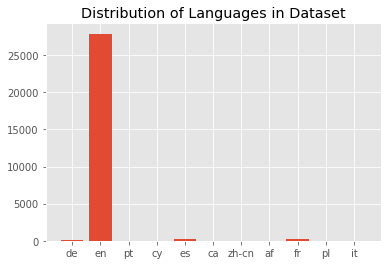

In [19]:
df_covid['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

For now we will drop any language that is not English. It may be worthwhile to translate these texts in the future

In [20]:
df_covid = df_covid[df_covid['language'] == 'en'] 
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27876 entries, 1053 to 30196
Data columns (total 12 columns):
paper_id               27876 non-null object
abstract               27876 non-null object
body_text              27876 non-null object
authors                27876 non-null object
title                  27876 non-null object
journal                27876 non-null object
abstract_summary       27876 non-null object
abstract_word_count    27876 non-null int64
body_word_count        27876 non-null int64
body_unique_words      27876 non-null int64
body_num_char          27876 non-null int64
language               27876 non-null object
dtypes: int64(4), object(8)
memory usage: 2.8+ MB


### Next lets create a function that will process the text data for us. 
For this purpose we will be using the nltk library. This function will convert text to lower case, remove punctuation, and find and remove stopwords (common words that will act as noise in the clustering step). The function can also try to determine the rootword of each token. This behavior is controlled by the stem boolean.

In [21]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
import string

def process_text(text, stem=True, delimiter=' '):
    
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()] 
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    if stem:
        stemmer = nltk.stem.PorterStemmer()
        words = [stemmer.stem(w) for w in words]
 
    processed = "".join([delimiter + i for i in words]).strip()
    return processed

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\solon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\solon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
df_covid['processed_body'] = df_covid.apply(lambda x: process_text(x['body_text'], stem=False), axis=1)
df_covid['processed_abstract'] = df_covid.apply(lambda x: process_text(x['abstract'], stem=False), axis=1)

### Let's take a look at word cout in the papers

In [23]:
import seaborn as sns

count     27876.000000
mean       4663.157627
std        5151.657211
min          12.000000
25%        2588.000000
50%        3803.000000
75%        5523.000000
max      232431.000000
Name: body_word_count, dtype: float64

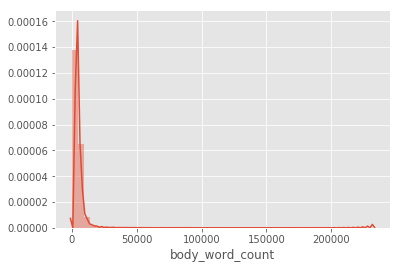

In [24]:
sns.distplot(df_covid['body_word_count'])
df_covid['body_word_count'].describe()

count    27876.000000
mean      1429.250789
std        928.028261
min         12.000000
25%        958.000000
50%       1276.000000
75%       1689.000000
max      30523.000000
Name: body_unique_words, dtype: float64

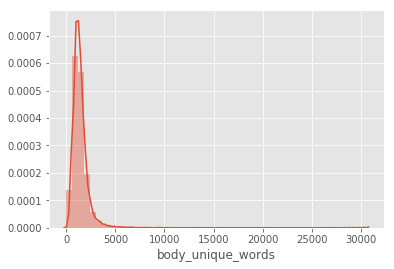

In [25]:
sns.distplot(df_covid['body_unique_words'])
df_covid['body_unique_words'].describe()

These two plots give us a good idea of the content we are dealing with. Most papers are about 5000 words in length. The long tails in both plots are caused by outliers. In fact, ~98% of the papers are under 20,000 words in length while a select few are over 200,000! <br><br>

Lets create a copy of our covid_df so that we can work with it without making changes to it directly

In [26]:
#df = df_covid.copy()
df = df_covid[df_covid['body_word_count'] < 20000]

count    27595.000000
mean      4313.968110
std       2685.567949
min         12.000000
25%       2572.000000
50%       3775.000000
75%       5454.000000
max      19990.000000
Name: body_word_count, dtype: float64

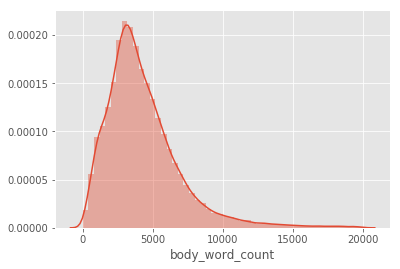

In [27]:
sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

count    27595.000000
mean      1371.142272
std        650.465451
min         12.000000
25%        954.000000
50%       1270.000000
75%       1671.000000
max       5929.000000
Name: body_unique_words, dtype: float64

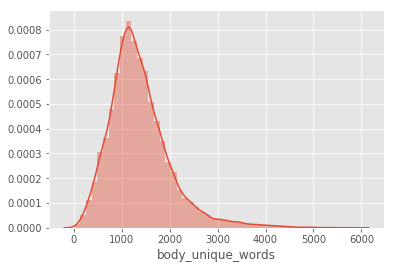

In [28]:
sns.distplot(df['body_unique_words'])
df['body_unique_words'].describe()

### Pickle dataframe for future use

In [29]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("plot_data/df.p", "wb" ))

# Clustering

In [34]:
df_sample = df.sample(6000)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

vectorizer = TfidfVectorizer(tokenizer=word_tokenize,
                             max_df=0.5,
                             min_df=0.1,
                             max_features=6000)

X = vectorizer.fit_transform(df_sample['processed_body'].values)
print(X.shape)

pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(X.toarray())  


min_range = 2
max_range = 20
distorsions = []
for k in range(min_range, max_range):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_result)
    distorsions.append(kmeans.inertia_)

(6000, 1845)


In [37]:
kmeans = KMeans(n_clusters=18)
y = kmeans.fit_predict(pca_result)

In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.821s...
[t-SNE] Computed neighbors for 6000 samples in 127.532s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.298817
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.848518
[t-SNE] KL divergence after 1000 iterations: 1.958338


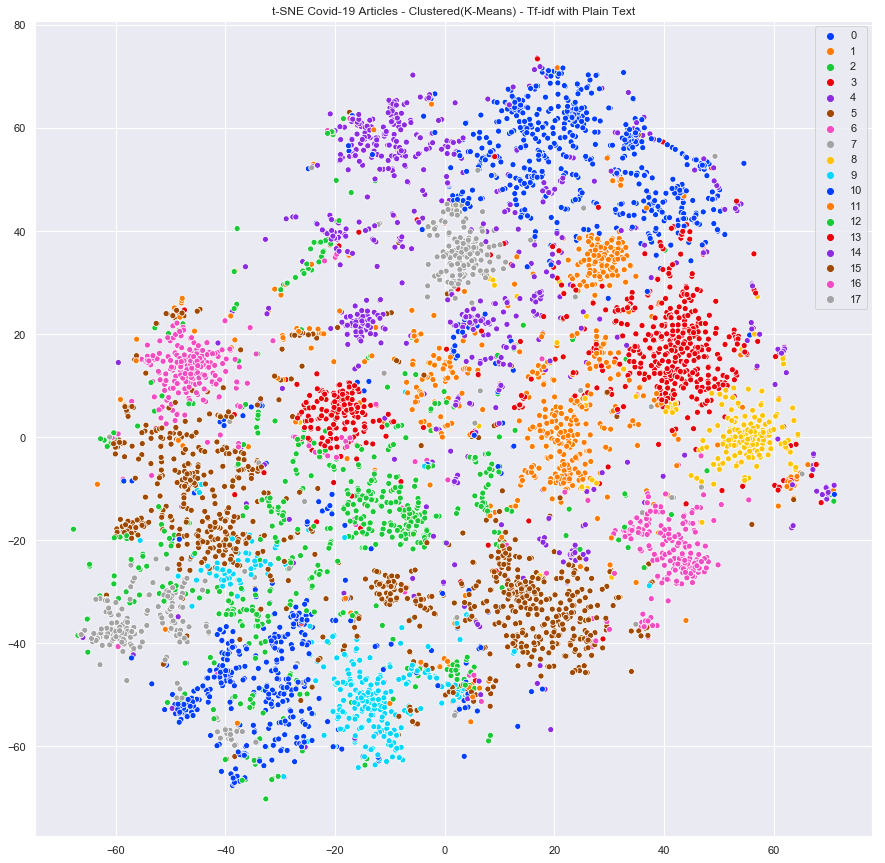

In [39]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered(K-Means) - Tf-idf with Plain Text")
plt.savefig("plots/t-sne_covid19_label_TFID.png")
plt.show()

### Sentence Clustering

In [112]:
data = df_sample
data.dropna(subset=['body_text'])

,paper_id,abstract,body_text,authors,title,journal,abstract_summary,abstract_word_count,body_word_count,body_unique_words,body_num_char,language,processed_body,processed_abstract
29696,b41e1c74739ae2195dc07a54fd9decaff5639b45,Secondary lymphoid organ chemokine (SLC) is ex...,S econdary lymphoid organs are the predominant...,"Gunn, Michael D.. Kyuwa, Shigeru...",Mice Lacking Expression of Secondary Lymphoid...,J Exp Med,Secondary lymphoid organ chemokine (SLC) is<b...,193,5608,1554,32545,en,econdary lymphoid organs predominant site lymp...,secondary lymphoid organ chemokine slc express...
21482,a087f807e9d36684bc1bd514ac9263394b65a8c4,,Effective personal protective clothing for hea...,"Wong, Thomas K.S. Chung, Joanne W.Y...",Effective personal protective clothing for<br...,American Journal of Infection Control,Not provided.,0,3073,978,18454,en,effective personal protective clothing health ...,
8635,e3c22f7e1409db69c1be9a7ae76319405506aaea,Background: Phylogenetic analysis is now an im...,Evolutionary and phylogenetic analysis has bec...,"Dellicour, Simon. Rose, Rebecca...",Explaining the geographic spread of emerging<...,BMC Bioinformatics,Background: Phylogenetic analysis is now an<b...,270,5471,1462,35261,en,evolutionary phylogenetic analysis become impo...,background phylogenetic analysis important too...
26278,e24f82ec9a924973e34c38e76e8018d1d7a12a44,Electron tomography (ET) is a three-dimensiona...,"More than half a century ago, when cellular sa...","Bárcena, Montserrat. Koster, Abraham J.",Electron tomography in life science,Seminars in Cell & Developmental Biology,Electron tomography (ET) is a<br>three-dimens...,134,5997,2089,39230,en,half century ago cellular samples prepared exa...,electron tomography et threedimensional techni...
29791,c2d4efc02a8e37fb93eafe7ddb9eff42e0c600b2,China ratified the International Covenant on E...,"On August 23, 2016, Philip Alston, the United ...","Qiu, Shengnan. Macnaughton, Gillian",Mechanisms of Accountability for the<br>Reali...,Health Hum Rights,China ratified the International Covenant on<...,164,6393,1853,43064,en,august philip alston united nations un special...,china ratified international covenant economic...
18041,72b6c3099754b379c29cfb4c84ee9f98c0fe46f8,The severe combined immunodeficient (SCID) mou...,In view of its limited ability to mount an imm...,"Koo, Gloria C. Hasan, Aisha...",Use of humanized severe combined<br>immunodef...,Expert Review of Vaccines,The severe combined immunodeficient (SCID)<br...,292,3750,1220,24124,en,view limited ability mount immune response for...,severe combined immunodeficient scid mouse ada...
15534,5131c8c19a90bd84b3f8146eec14ad48aadcde41,DNA hydrogels as special members in the DNA na...,Hydrogels are 3-D hydrophilic buildings coveri...,"Khajouei, Sima. Ravan, Hadi...",DNA hydrogel-empowered biosensing,Advances in Colloid and Interface Science,DNA hydrogels as special members in the DNA<b...,160,5790,1888,37878,en,hydrogels hydrophilic buildings covering nano ...,dna hydrogels special members dna nanotechnolo...
16509,5eb9b4024c208f9f6281076b8bab62985135a091,Canine parvovirus (CPV) and canine coronavirus...,viruses with a large genome of 27-31 kb in len...,"McElligott, Susan. Collins, P. J....",Detection and genetic characterization of<br>...,Arch Virol,Canine parvovirus (CPV) and canine<br>coronav...,179,3456,1164,21635,en,viruses large genome kb length enteric canine ...,canine parvovirus cpv canine coronavirus ccov ...
10818,116e55aaa621e0a80dedc594fdd42c12090516c0,,"Initially discovered half a century ago, cytok...","Fink, Karin. Grandvaux, Nathalie",STAT2 and IRF9: Beyond ISGF3,JAK-STAT,Not provided.,0,4401,1299,29627,en,initially discovered half century ago cytokine...,
23175,b6aa15f12a5c4f0e48f85a5d53edc2d10e127ed8,,We used data on age and sex for 136 laboratory...,"Dudley, Joseph P.. Mackay, Ian M.",Age-specific and sex-specific morbidity and<b...,Journal of Clinical Virology,Not provided.,0,1606,584,9938,en,used data age sex laboratory

In [113]:
from nltk.tokenize import sent_tokenize


all_sentences = []  # stores all sentences in dataframe
last_sentence = []  # stores the sentence number that is first for paper in dataframe
count = 0 
for ii in range(len(data)):
    
    sentences = sent_tokenize(data.iloc[ii]['body_text'])
    processed = []
    for sentence in sentences:
        clean_sentence = process_text(sentence, stem=False)
        all_sentences.append(clean_sentence)
        count += 1
        
    last_sentence.append(count)

    
data['last_sentence_num'] = last_sentence
    

In [114]:
#all_sentences = [item for sublist in all_sentences for item in sublist]
#print(all_sentences)

In [115]:
vectorizer = TfidfVectorizer(max_features=2**11)
X = vectorizer.fit_transform(all_sentences)

In [116]:
X.shape

(1099061, 2048)

In [117]:
pca = PCA(n_components=0.95)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

MemoryError: 

In [ ]:
from sklearn.cluster import MiniBatchKMeans

k = 30
kmeans = MiniBatchKMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X_reduced)

In [ ]:
y_pred.shape

In [ ]:
data.head()

In [ ]:
def most_common(lst):
    return max(set(lst), key=lst.count)
               
previous = 0
labels = []
y = list(y_pred)
for ii in range(len(data)):
    current = data.iloc[ii]['last_sentence_num']
    best_label = most_common(y[previous:current + 1])
    labels.append(best_label)
    previous = current

In [ ]:
print(labels)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y)))

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=labels, legend='full', palette=palette)
plt.title("t-SNE Covid-19 Articles - Clustered(K-Means) - Tf-idf with Plain Text")
plt.savefig("plots/t-sne_covid19_label_TFID.png")
plt.show()